This notebook treats the harvesting process of the Slope covariate.
The source of the data is EarthEnv https://www.earthenv.org/topography.
EarthEnv provides free-of-charge data derived from the digital elevation product model 250m res. GMTED2010 incorporated with 90m res. SRTM4.1dev, at various resolution, with the higher one being 1km.

Visualize the .tif file.

In [ ]:
path = "C:\\Users\\Luca\\Downloads\\slope_1KMmn_GMTEDmd.tif"

C:\Users\Luca\AppData\Local\Programs\Python\Python310\lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


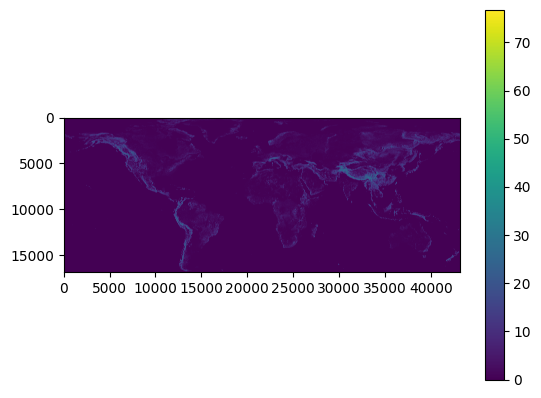

In [5]:
from osgeo import gdal

slope = gdal.Open(path)
slope_array = slope.ReadAsArray()

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(slope_array)
plt.colorbar()
plt.show()

Reading the file with rasterio and creating three arrays as slope, latitude, longitude

In [1]:
import rasterio as rio
import pandas as pd
import numpy as np

path = "C:\\Users\\Luca\\Downloads\\slope_1KMmn_GMTEDmd.tif"
with rio.open(path) as src:
    
    # Se lee la imagen
    print('reading...')
    image = src.read()
    
    # Dimensiones de la imagen
    print('getting shapes...')
    bands, rows, cols = np.shape(image)
    
    # La imagen 2D se convierte a 1D
    print('getting slopes...')
    image1 = image.reshape (rows*cols,bands)
    
    
    # bounding box de la imagen
    print('getting bounds...')
    l,b,r,t = src.bounds
    
    # Resolution of image
    print('getting resolution...')
    res = src.res
    
    # Coordenadas X
    print('getting the coordinates...')
    X = np.arange(l, r, res[0])
    
    # Coordenadas Y
    Y = np.arange(t, b, -res[0])

reading...
getting shapes...
getting slopes...
getting bounds...
getting resolution...
getting the coordinates...


In [2]:
len(image1)

725760000

In [3]:
len(image1[image1 > 0])

220665569

In [4]:
print(f'lat: {b,t}, lon: {l,r}')

lat: (-56.0, 84.0), lon: (-180.0, 180.0)


The slope data is expressed in degree angles; however we want it to be expressed in radiants.

In [5]:
image1.min(), image1.mean(), image1.max()

(0.0, 0.9418932, 76.73714)

In [6]:
import math

mi,mn,ma = image1.min(), image1.mean(), image1.max()

mi = mi * (math.pi/180)
mn = mn * (math.pi/180)
ma = ma * (math.pi/180)

mi,mn,ma

(0.0, 0.016439137890300503, 1.3393156964257542)

In [7]:
image1[image1 > 0]

array([0.00273449, 0.0293174 , 0.0309372 , ..., 0.6879716 , 0.1436202 ,
       0.0165833 ], dtype=float32)

Ideally, we would want to read the file as-is, convert coordinates to quadkey 14 tiles, group for quadkeys and be done with it, but the sheer amount of data has the task not pheasible as a whole. To avoid the problem, we'll use a batch-based approach as we have already seen with the Radiance dataset.
This time, as the number of different rows and columns seem to be easier to work with, we decide to find a number of batch containing a number of units equal to a multiple of the different values of longitude. We choose to work with 20 batches of 36,288,000 units each.

In [8]:
k = 0
for i in range(1, len(image1)):
    if (16800%i == 0) & (43200%i == 0):
        k +=1
        print(f'{i} --> {len(image1)/i}')
    if k >= 15:
        break

1 --> 725760000.0
2 --> 362880000.0
3 --> 241920000.0
4 --> 181440000.0
5 --> 145152000.0
6 --> 120960000.0
8 --> 90720000.0
10 --> 72576000.0
12 --> 60480000.0
15 --> 48384000.0
16 --> 45360000.0
20 --> 36288000.0
24 --> 30240000.0
25 --> 29030400.0
30 --> 24192000.0


In [7]:
from pyquadkey2 import quadkey

In [8]:
36288000/16800, 36288000/43200

(2160.0, 840.0)

We're going to illustrate how the process work for a single batch. We create a dataset with the first 36,288,000 values of slope.

In [9]:
nbatch = 20
len_batch = int(len(image1)/nbatch)
len_batch

36288000

In [12]:
data = image1[:len_batch]
data = pd.DataFrame(data)
data.columns = ['slope']
data

,slope
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
36287995,0.0
36287996,0.0
36287997,0.0
36287998,0.0


As we already explained in the Radiance file, we can prove that the position of a slope value in a flattened array is equal to the i-th longitude and the j-th latitude value, with i being the remainder of the division between the index value of the slope and the number of different longitude values, and j being the integer result of the same operation.
Below, we can see that the first excluded value will have the west-most longitude value, as expected since we made sure that every batch contains a multiple number of the total longitude values.

In [13]:
Y[len_batch//len(X)], X[len_batch%len(X)]

(76.99999999999443, -180.0)

In [14]:
data['longitude'] = X[(data.index)%len(X)]
data['latitude'] = Y[(data.index)//len(X)]

In [15]:
data

,slope,longitude,latitude
0,0.0,-180.000000,84.000000
1,0.0,-179.991667,84.000000
2,0.0,-179.983333,84.000000
3,0.0,-179.975000,84.000000
4,0.0,-179.966667,84.000000
...,...,...,...
36287995,0.0,179.958333,77.008333
36287996,0.0,179.966667,77.008333
36287997,0.0,179.975000,77.008333
36287998,0.0,179.983333,77.008333


From here onwards, it's all smooth-sailing: we derived a subset of the entire file and we can then assign to each point its own quadkey 14 tile via the quadkey.from_geo() function, then group for quadkey and take the mean of the points within the same tile as an estimate of the tile's true slope value.

In [16]:
import time
start = time.time()
data['quadkey'] = data.apply(lambda x: str(quadkey.from_geo((x['latitude'], x['longitude']), 14)), axis=1)
print(f'quadkeys extracted in {time.time()-start}s')

data = data.groupby('quadkey', as_index = False)['slope'].mean()
print(f'dataset grouped in {time.time()-start}s')
data

quadkeys extracted in 670.44349360466s
dataset grouped in 700.5268416404724s


,quadkey,slope
0,00000222220220,0.0
1,00000222220221,0.0
2,00000222220230,0.0
3,00000222220231,0.0
4,00000222220320,0.0
...,...,...
13762555,11311333133311,0.0
13762556,11311333133320,0.0
13762557,11311333133321,0.0
13762558,11311333133330,0.0


The first batch is composed of the north-most elements, and as such is expected to be very little slope in the subset (notice that we still haven't properly converted the values from degree angles to radiants.)

In [17]:
data.describe()

,slope
count,1.376256e+07
mean,4.243877e-01
std,1.848432e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,4.513549e+01


In [18]:
cart = "C:\\Users\\Luca\\Downloads\\RWI\\slope"
data.to_csv(f'{cart}\\slope_0.csv', index = False)

Afterwards, the process is automated to work with each remaining batch. The process was halted around the 17-th iteration to allow the hard drive to cool down, and then resumed in the following code chunk.

In [20]:
cart = "C:\\Users\\Luca\\Downloads\\RWI\\slope"

for i in range(1, 20):
    print(f'starting iteration {i}...')
    start = i*len_batch
    end = (i+1)*len_batch

    print('getting the slope values...')
    data = image1[start:end]

    print('converting to dataframe...')
    data = pd.DataFrame(data)
    data.columns = ['slope']

    print('getting locations...')
    data['longitude'] = X[(i*len_batch + data.index)%len(X)]
    data['latitude'] = Y[(i*len_batch + data.index)//len(X)]

    print(f'forma dataset: {data.shape}')
    print(f'lat: {data.latitude.min(), data.latitude.max()}')
    print(f'stat dataset (min, media, mediana, max): {data.slope.min(), data.slope.mean(), data.slope.median(), data.slope.max()}')
    
    print('getting quadkeys...')
    data['quadkey'] = data.apply(lambda x: str(quadkey.from_geo((x['latitude'], x['longitude']), 14)), axis=1)

    print('grouping for quadkey and exporting...')
    data = data.groupby('quadkey', as_index = False)['slope'].mean()

    print(data.shape)
    
    data.to_csv(f'{cart}\\slope_{i}.csv', index = False)

    print(f'iteration {i} complete...')
    print('-' * 40)

starting iteration 1...
getting the slope values...
converting to dataframe...
getting locations...
forma dataset: (36288000, 3)
lat: (70.0083333333222, 76.99999999999443)
stat dataset (min, media, mediana, max): (0.0, 0.5060398, 0.0, 50.827606)
getting quadkeys...
grouping for quadkey and exporting...
(13762560, 2)
iteration 1 complete...
----------------------------------------
starting iteration 2...
getting the slope values...
converting to dataframe...
getting locations...
forma dataset: (36288000, 3)
lat: (63.00833333331663, 69.99999999998886)
stat dataset (min, media, mediana, max): (0.0, 1.9900805, 0.6178475, 56.711395)
getting quadkeys...
grouping for quadkey and exporting...
(12943360, 2)
iteration 2 complete...
----------------------------------------
starting iteration 3...
getting the slope values...
converting to dataframe...
getting locations...
forma dataset: (36288000, 3)
lat: (56.00833333331106, 62.99999999998329)
stat dataset (min, media, mediana, max): (0.0, 1.86606

KeyboardInterrupt: 

In [10]:
cart = "C:\\Users\\Luca\\Downloads\\RWI\\slope"

for i in range(16, 20):
    print(f'starting iteration {i}...')
    start = i*len_batch
    end = (i+1)*len_batch

    print('getting the slope values...')
    data = image1[start:end]

    print('converting to dataframe...')
    data = pd.DataFrame(data)
    data.columns = ['slope']

    print('getting locations...')
    data['longitude'] = X[(i*len_batch + data.index)%len(X)]
    data['latitude'] = Y[(i*len_batch + data.index)//len(X)]

    print(f'forma dataset: {data.shape}')
    print(f'lat: {data.latitude.min(), data.latitude.max()}')
    print(f'stat dataset (min, media, mediana, max): {data.slope.min(), data.slope.mean(), data.slope.median(), data.slope.max()}')
    
    print('getting quadkeys...')
    data['quadkey'] = data.apply(lambda x: str(quadkey.from_geo((x['latitude'], x['longitude']), 14)), axis=1)

    print('grouping for quadkey and exporting...')
    data = data.groupby('quadkey', as_index = False)['slope'].mean()

    print(data.shape)
    
    data.to_csv(f'{cart}\\slope_{i}.csv', index = False)

    print(f'iteration {i} complete...')
    print('-' * 40)

starting iteration 16...
getting the slope values...
converting to dataframe...
getting locations...
forma dataset: (36288000, 3)
lat: (-34.99166666676136, -28.00000000008913)
stat dataset (min, media, mediana, max): (0.0, 0.36419356, 0.0, 51.322037)
getting quadkeys...
grouping for quadkey and exporting...
(6127616, 2)
iteration 16 complete...
----------------------------------------
starting iteration 17...
getting the slope values...
converting to dataframe...
getting locations...
forma dataset: (36288000, 3)
lat: (-41.99166666676693, -35.0000000000947)
stat dataset (min, media, mediana, max): (0.0, 0.1854996, 0.0, 43.97935)
getting quadkeys...
grouping for quadkey and exporting...
(6684672, 2)
iteration 17 complete...
----------------------------------------
starting iteration 18...
getting the slope values...
converting to dataframe...
getting locations...
forma dataset: (36288000, 3)
lat: (-48.99166666677252, -42.00000000010027)
stat dataset (min, media, mediana, max): (0.0, 0.20

The final dataset is created as the concatenation of the different subsets. Note that there exist multiple tiles that were 'truncated' between different batches, and as such each carry a specific estimate value. Merging the same tiles using again the mean as an estimate isn't mathematically correct, but we expect the changes to be minimal so we do it either way.

In [2]:
import pandas as pd
import os

cart = "C:\\Users\\Luca\\Downloads\\RWI\\slope"
data = pd.DataFrame(columns = ['quadkey', 'slope'])

for file in os.listdir(cart):
    temp = pd.read_csv(f'{cart}\\{file}')

    print(f'{file}: {temp.shape}')

    data = pd.concat([data, temp], ignore_index = True)
    print(f'appended. current shape: {data.shape}')

slope_0.csv: (13762560, 2)


C:\Users\Luca\AppData\Local\Temp\ipykernel_25312\2402837358.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, temp], ignore_index = True)


appended. current shape: (13762560, 2)
slope_1.csv: (13762560, 2)
appended. current shape: (27525120, 2)
slope_10.csv: (5324800, 2)
appended. current shape: (32849920, 2)
slope_11.csv: (5242880, 2)
appended. current shape: (38092800, 2)
slope_12.csv: (5226496, 2)
appended. current shape: (43319296, 2)
slope_13.csv: (5324800, 2)
appended. current shape: (48644096, 2)
slope_14.csv: (5488640, 2)
appended. current shape: (54132736, 2)
slope_15.csv: (5750784, 2)
appended. current shape: (59883520, 2)
slope_16.csv: (6127616, 2)
appended. current shape: (66011136, 2)
slope_17.csv: (6684672, 2)
appended. current shape: (72695808, 2)
slope_18.csv: (7471104, 2)
appended. current shape: (80166912, 2)
slope_19.csv: (8601600, 2)
appended. current shape: (88768512, 2)
slope_2.csv: (12943360, 2)
appended. current shape: (101711872, 2)
slope_3.csv: (10338304, 2)
appended. current shape: (112050176, 2)
slope_4.csv: (8617984, 2)
appended. current shape: (120668160, 2)
slope_5.csv: (7471104, 2)
appended.

In [3]:
data = data.groupby('quadkey', as_index = False).mean()

In [4]:
len(data)

152059904

In [5]:
data.to_csv(f'{cart}\\slope_quadkeys.csv', index = False)

A subset consisting of only quadkeys that will be used in our study, whether they be training data or score data, is taken.

In [ ]:
import pandas as pd

file = "C:\\Users\\Luca\\Downloads\\RWI\\slope\\slope_quadkeys.csv"

data = pd.read_csv(file)
data.head()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152059904 entries, 0 to 152059903
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   quadkey  object 
 1   slope    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ GB


In [7]:
with open('quad_paesi2.txt', 'r') as file:
    list_quads = file.read()
    list_quads = list_quads.split(',')

In [8]:
len(list_quads)

3839219

In [10]:
data = data.astype({'quadkey': 'str'})

In [11]:
df = data[data.quadkey.isin(list_quads)]
len(df)

3838986

In [12]:
df.to_csv("C:\\Users\\Luca\\Downloads\\RWI\\slope\\slope_quadkeys_utili.csv", index = False)

Notice that there are some missing tiles, mainly related to the Scandinavian Peninsula, which were for the most part missing in the Elevation dataset as well (which is understandable, given how the slope data is derived from the elevation data). As the number of missing data is very low, we decided to not press further and just use imputation afterwards.

In [13]:
len(df) - len(list_quads)

-233

In [14]:
missing = set(list_quads) - set(df.quadkey)

In [15]:
with open('slope_miss.txt', 'w') as file:
    file.write(','.join(missing))

In [16]:
from pyquadkey2 import quadkey

for miss in missing:
    print(quadkey.from_str(miss).to_geo())

(68.966278627247, 26.96044921875)
(67.941650035335, 14.96337890625)
(70.274289676146, 22.12646484375)
(70.757965626549, 27.333984375)
(70.132898439953, 29.02587890625)
(68.807985556146, 17.0947265625)
(68.616533685343, 21.68701171875)
(68.374900160668, 23.5546875)
(67.941650035335, 12.9638671875)
(70.866290562904, 28.916015625)
(69.44984199907, 30.03662109375)
(67.941650035335, 15.49072265625)
(70.058091853719, 24.89501953125)
(70.132898439953, 22.5)
(68.807985556146, 16.1279296875)
(69.983015102873, 23.44482421875)
(69.824470773937, 27.00439453125)
(69.341588170537, 27.22412109375)
(70.39997823747, 28.212890625)
(68.374900160668, 22.78564453125)
(70.058091853719, 22.43408203125)
(69.907667341085, 23.2470703125)
(68.616533685343, 14.47998046875)
(70.699951294425, 23.818359375)
(70.699951294425, 27.4658203125)
(70.649050770164, 23.642578125)
(70.132898439953, 29.72900390625)
(68.807985556146, 17.38037109375)
(69.983015102873, 23.3349609375)
(70.649050770164, 23.66455078125)
(69.90766734

In [28]:
with open('elev_miss.txt', 'r') as file:
    miss2 = file.read()
    miss2 = miss2.split(',')
len(miss2)

236

In [29]:
same = []
for miss1 in missing:
    for mis2 in miss2:
        if miss1 == mis2:
            same.append(miss1)
same

['10232033023013',
 '10223111303331',
 '10230233213300',
 '10232102101003',
 '10223122203212',
 '10230322122302',
 '10232121032133',
 '10232003103123',
 '10232002000002',
 '10223033213312',
 '10232002121213',
 '10232013203121',
 '10223113113123',
 '10232002122232',
 '10230222332122',
 '10232103001003',
 '10223122212313',
 '10232002120312',
 '10230222332123',
 '10223113122322',
 '10223111331222',
 '10232013032222',
 '10232002121212',
 '10232011010133',
 '10223111110132',
 '10230223032212',
 '10230322123213',
 '10232001131300',
 '10232103230312',
 '10232021132032',
 '10232103231213',
 '10232013221312',
 '10232013221302',
 '10232001310213',
 '10232002120303',
 '10232103231212',
 '10223113023232',
 '10230233213301',
 '10232003103133',
 '10232002121303',
 '10232011021201',
 '10232033023012',
 '10223122213202',
 '10232002120212',
 '10232102101002',
 '10232120101012',
 '10223112032332',
 '10232003112032',
 '10232120321333',
 '10232103221202',
 '10223112103033',
 '10230323223023',
 '1023210131

In [33]:
len(same), len(missing) + len(miss2)

(146, 469)

In [34]:
469 - 146

323

In [38]:
tot_miss = list(missing) + miss2
tot_miss = list(set(tot_miss))
len(tot_miss)

323

In [39]:
with open('slope_elev_miss.txt', 'w') as file:
    file.write(','.join(tot_miss))